In [1]:
# Notebook for Testing
# https://signal.vercel.app/edit
# https://github.com/lolzone13/Markov-Music.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.1/51.1 kB 2.6 MB/s eta 0:00:00


### Imports

In [1]:
import mido
from music21 import converter, instrument, note, chord, stream
from mido import MidiFile
import numpy
import glob
import pickle
import numpy as np
import matplotlib.pyplot as plt
import string
import re
from Helper import Helper

### Plot Distribution of Notes in the MIDI File

In [9]:
def plot_notes_distribution(midi_arr, normalized=True):

    size, num_notes = midi_arr.shape
    notes_freq = np.zeros(num_notes)
    for i in range(size):
        for j in range(num_notes):
            if midi_arr[i, j] > 0:
                notes_freq[j] += 1
    if normalized:
        notes_freq /= np.sum(notes_freq)
    notes = []
    for f in notes_freq:
        notes += [f]*100
    plt.plot(np.linspace(0, num_notes, num_notes*100), notes, color='red')
    plt.xlabel('notes #')
    plt.ylabel('distribution')
    plt.title('Distribution of notes')
    plt.show()


In [38]:
# helper function to aid in conversion of MIDI files
helper = Helper()
mid = mido.MidiFile('../midi/NuvoleBianche.mid', clip=True)
midi_array = helper.mid2arry(mid)
midi_array

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

### Plots of the input MIDI file

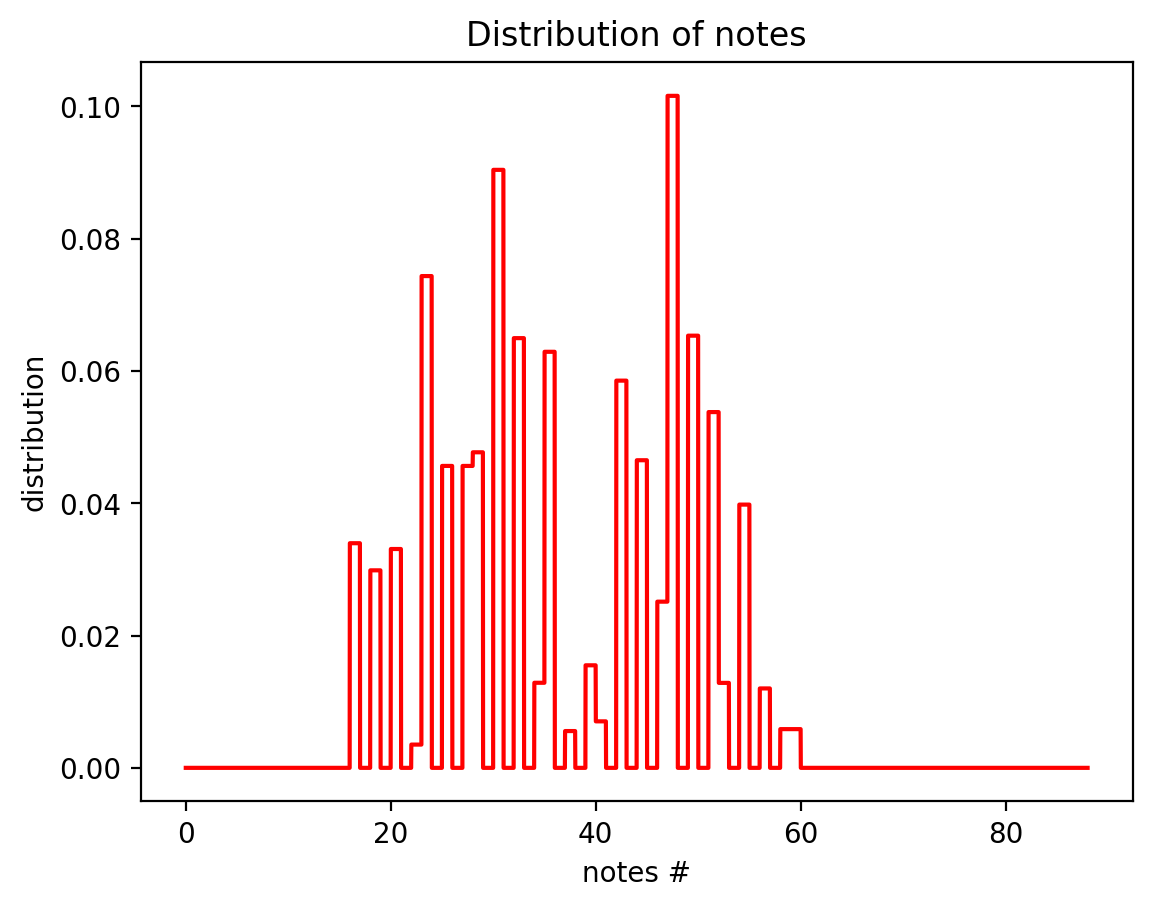

In [39]:
plot_notes_distribution(midi_array)

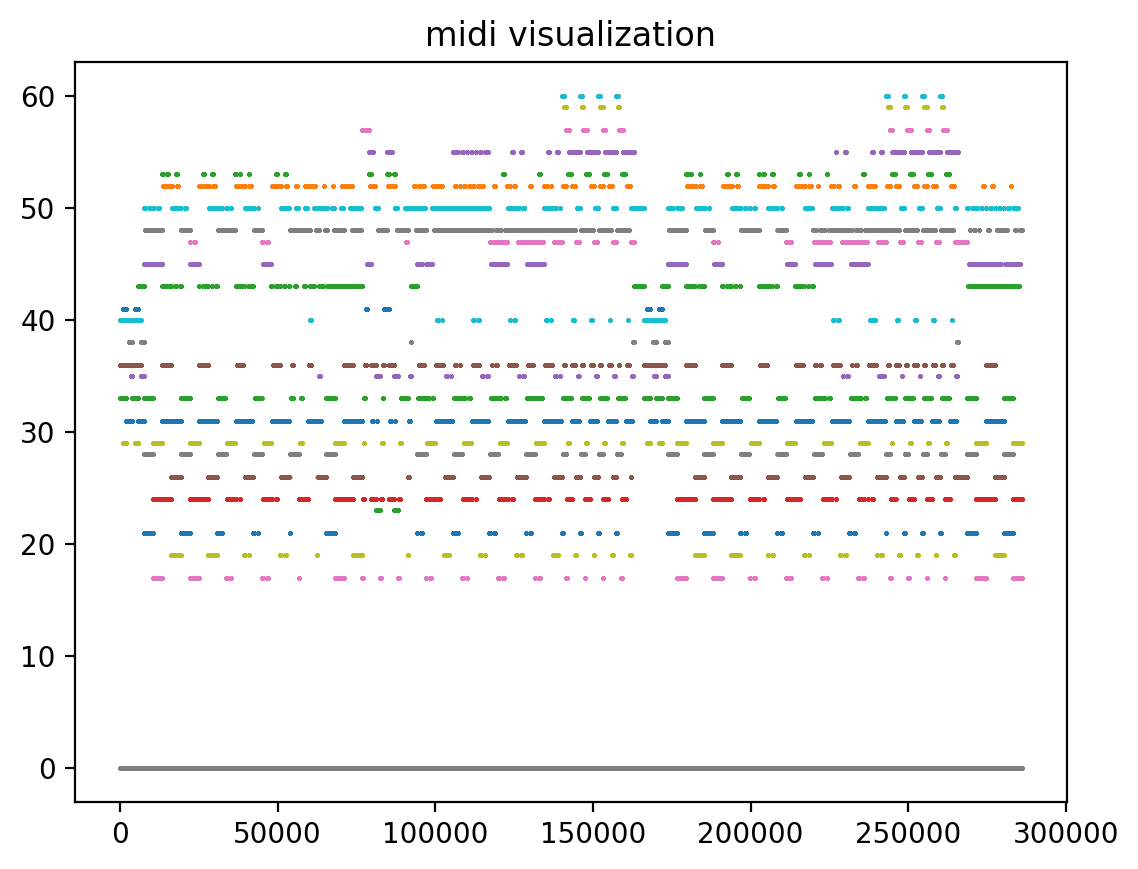

In [40]:
# MIDI Software Plots

plt.plot(range(midi_array.shape[0]), np.multiply(np.where(midi_array>0, 1, 0), range(1, 89)), marker='.', markersize=1, linestyle='')
plt.title("midi visualization")
plt.show()

In [41]:
# Store All Midi files of a folder into a single array

def get_midi_array(folder_path):
    midi_files = glob.glob('../midi/kaggle/*.mid')

    midi_array = np.empty((0, 88))
    for mi in midi_files:
        mid = mido.MidiFile(folder_path + '/' + mi, clip=True)
        midi_arr = np.array(helper.mid2arry(mid))
        midi_array = np.concatenate((midi_array, midi_arr), axis=0)

    return midi_array

In [42]:
# Run Length Encoding to Generate States

def encode_vector_to_state(v):
  state = ""
  cnt = 1
  n = v.size
  for i in range(1,n):
    if v[i] == v[i-1]:
      cnt +=1
    else:
      state += str(v[i-1]) + 'x' + str(cnt) + '-'
      cnt = 1
  
  state += str(v[-1]) + 'x' + str(cnt)
  return state
  
# print(encode_vector_to_state(np.array([0,0,1,1,1,1,4,5,0,0,0,0,0,45,0,0,0,0])))

def decode_state_to_vector(state):
  v = []
  uniq = state.split('-')
  for el in uniq:
    num, cnt = el.split('x')
    v += [int(float(num))]*int(float(cnt))
  return np.array(v)

# print(decode_state_to_vector('0x2-1x4-4x1-5x1-0x5-45x1-0x4'))

In [43]:
# Generating states according to unique rows in MIDI array

uniq_midi_rows = np.unique(midi_array, axis=0)
print(uniq_midi_rows.shape)
print("uniq/total % = ", 100*uniq_midi_rows.shape[0]/midi_array.shape[0])
num_states = uniq_midi_rows.shape[0]

(244, 88)
uniq/total % =  0.08529142401722607


In [44]:
# Generating all the states

states = [encode_vector_to_state(uniq_midi_rows[i]) for i in range(num_states)]
print(states[0:10])

['0x88', '0x59-80x1-0x28', '0x58-80x1-0x29', '0x56-64x1-0x31', '0x56-80x1-0x31', '0x54-80x1-0x33', '0x51-64x1-0x36', '0x49-64x1-0x38', '0x47-56x1-0x40', '0x47-60x1-0x40']


In [45]:
# transition matrix

def get_transition_probabilities(midi_array, num_states, states, epsilon=1e-12):

    transition_prob = np.zeros((num_states, num_states))
    # now fill it
    for i in range(midi_array.shape[0]-1):
        curr_st = encode_vector_to_state(midi_array[i])
        next_st = encode_vector_to_state(midi_array[i+1])
        transition_prob[states.index(curr_st), states.index(next_st)] += 1

    # now normalize to make it probability distribution
    for i in range(num_states):
        sum = np.sum(transition_prob[i])
        transition_prob[i] = transition_prob[i]/(sum + epsilon)
        err = 1 - np.sum(transition_prob[i])
        transition_prob[i, 0] += err

    return transition_prob

transition_probabilities = get_transition_probabilities(midi_array, num_states, states)


In [46]:
print(np.sum(transition_probabilities[0]))
print(transition_probabilities[0])
transition_probabilities[:5, :5]

1.0
[1.99840144e-15 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 0.00000000e+00 8.13008130e-03
 0.00000000e+00 1.62601626e-02 1.62601626e-02 0.00000000e+00
 0.00000000e+00 0.00000000e+00 8.13008130e-03 1.62601626e-02
 0.00000000e+00 0.00000000e+00 0.00000000e+00 2.43902439e-02
 2.43902439e-02 8.13008130e-03 0.00000000e+00 0.00000000e+00
 0.00000000e+00 2.03252033e-03 2.03252033e-03 0.00000000e+00
 2.03252033e-03 0.00000000e+00 0.00000000e+00 1.62601626e-02
 1.62601626e-02 0.00000000e+00 0.00000000e+00 0.00000000e+00
 0.00000000e+00 6.09756098e-03 1.62601626e-02 0.00000000e+00
 0.00000000e+00 0.00

array([[1.99840144e-15, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [8.32667268e-14, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [8.32667268e-14, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [1.66755498e-13, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00],
       [4.98490138e-14, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00]])

In [47]:
def random_walk(transition_prob, init_state = 0, WALK_LENGTH = 100000):
  '''
  returns seq. of index of states
  '''
  num_states = transition_prob.shape[0]
  walk = []
  curr_st = init_state
  for i in range(WALK_LENGTH):
    walk.append(curr_st)
    next_st = np.random.choice(np.arange(num_states), p=transition_prob[curr_st])
    curr_st = next_st
  
  return np.array(walk) 


In [48]:
generated_midi_seq_idx = random_walk(transition_probabilities, 0)
print(generated_midi_seq_idx[:100])

[  0 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126 126
   7  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80
  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80
  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80
  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80  80
  80  80  80  80  80  80  80  80  80  80]


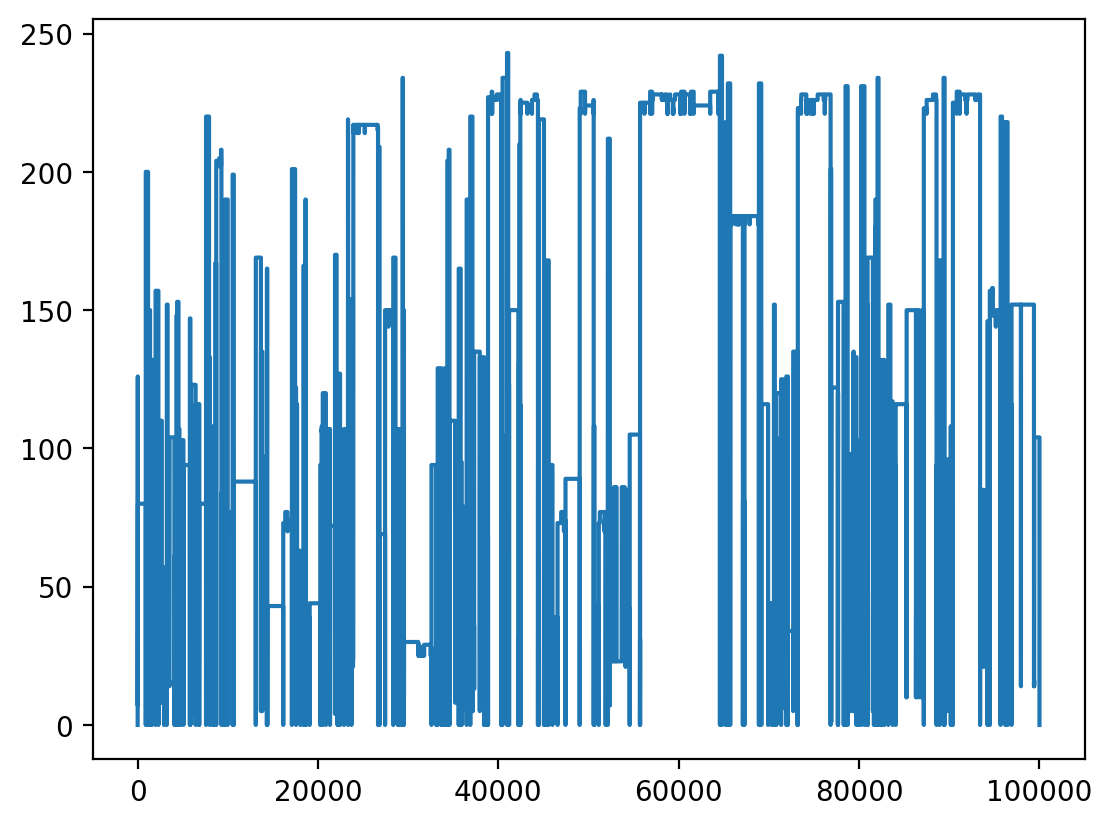

In [49]:
# plot of generated MIDI sequence
plt.plot(generated_midi_seq_idx)

In [50]:
# Decoding the generated music file

generated_midi_array = np.zeros((generated_midi_seq_idx.size, 88))
i = 0
for idx in generated_midi_seq_idx:
  state = states[idx]
  vector = decode_state_to_vector(state).reshape(1,-1)
  generated_midi_array[i] = vector
  i += 1

generated_midi_array = generated_midi_array.astype('int')

### Distribution of Generated Song

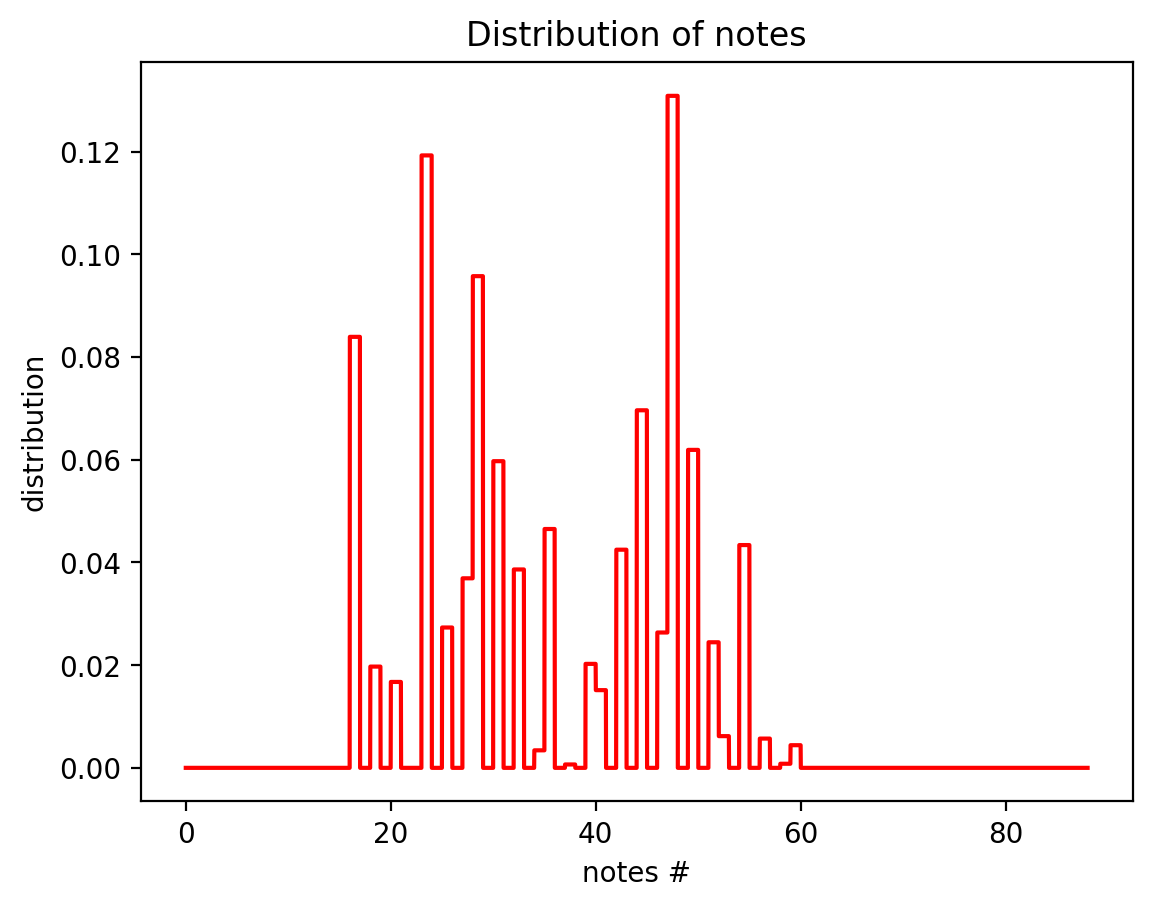

In [51]:
plot_notes_distribution(generated_midi_array)

In [52]:
# Finding the Mean of the tempo in the midi file

def get_tempo(mid):
  track_info = ''
  for m in mid.tracks[0]:
    track_info += str(m)


  tempos_str = re.findall(r'tempo=(.*?),',track_info)
  tempos = np.array([int(t) for t in tempos_str])
  # print('tempo mean:', int(np.mean(tempos)),'max:', np.max(tempos),'min:',np.min(tempos))
  return int(np.mean(tempos))

In [53]:
# A tempo marking of 60 BPM equals one beat per second

avg_tempo = get_tempo(mid)

mid_new = helper.arry2mid(generated_midi_array, avg_tempo)
mid_new.save('midi_generated_1.mid')

In [54]:
# playing music
import pygame

pygame.init()
pygame.mixer.music.load(r'midi_generated_1.mid')
pygame.mixer.music.play()

while pygame.mixer.music.get_busy():
    pygame.time.wait(1000)

pygame 2.3.0 (SDL 2.24.2, Python 3.11.0)
Hello from the pygame community. https://www.pygame.org/contribute.html


KeyboardInterrupt: 

In [ ]:
'''
In midi files, each Note has a distinct midi number ranging from 21 to 108
Dimension = n rows * 88 columns, each row contains the state of 88 notes at a particular time step. The notes out of piano keyboard range will be ignored.
The values in the array represent velocity (0 means note off, while (0:127] means note on).
'''